# Imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from kydavra import PValueSelector, LassoSelector
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import pointbiserialr, uniform
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.svm import SVR
import lime

# Loading datasets
We are going to have 2 datasets for this study: one for classification with pokemons and one for regression with car data.

In [28]:
class_df = pd.read_csv('Pokemon.csv')
car_df = pd.read_csv('Dataset.csv')

## Pokemons

In [29]:
class_df.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

The dataset has the following structure:
- **#**: ID for each pokemon
- **Name**: Name of each pokemon
- **Type 1**: Each pokemon has a type, this determines weakness/resistance to attacks
- **Type 2**: Some pokemon are dual type and have 2
- **Total**: sum of all stats that come after this, a general guide to how strong a pokemon is
- **HP**: hit points, or health, defines how much damage a pokemon can withstand before fainting
- **Attack**: the base modifier for normal attacks (eg. Scratch, Punch)
- **Defense**: the base damage resistance against normal attacks
- **SP Atk**: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
- **SP Def**: the base damage resistance against special attacks
- **Speed**: determines which pokemon attacks first each round
- **Generation**: the generation of the pokemons. 
- **Legendary**: whatever if the pokemon is considered legendary or not. Probably our target column.


In [30]:
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Our data columns are mostly integer except Type 1, Type 2, Name which are string and legendary which is boolean. And we have insufficient data for Type2.

In [31]:
class_df.describe()

#      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.00000  
50%     70.000000   65.000000     3.00000  
75%     90.000000   90.000000     5.00000  
max    230.000000  180.000000     6.00000

### Data preprocessing
Firstly, we should drop # and name columns as it is irredundant for our study.

In [32]:
class_df.drop('#', inplace=True, axis='columns')
class_df.drop('Name', inplace=True, axis='columns')

Secondly, we must encode Type 1 and Type 2 columns but firstly we should see their data.

In [33]:
class_df['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [34]:
class_df['Type 2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

These columns store categorical data. Also the data is similar, the only difference is that a pokemon can have type 1 but type 2 is optional, we should this in consideration.

In [35]:
nan_index = class_df.index[class_df['Type 2'].isnull()]
encoder = TargetEncoder()

class_df['Type 1'] = encoder.fit_transform(class_df[['Type 1']], class_df['Generation'])
class_df['Type 2'] = encoder.fit_transform(class_df[['Type 2']], class_df['Generation'])

class_df

Type 1    Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
0    0.155868  0.584753    318  45      49       49       65       65     45   
1    0.155868  0.567911    405  60      62       63       80       80     60   
2    0.155885  0.587496    525  80      82       83      100      100     80   
3    0.207552  0.681484    625  80     100      123      122      120     80   
4    0.221814  0.226640    309  39      52       43       60       50     65   
..        ...       ...    ...  ..     ...      ...      ...      ...    ...   
795  0.205937  0.168448    600  50     100      150      100      150     50   
796  0.205937  0.159930    700  50     160      110      160      110    110   
797  0.200165  0.000000    600  80     110       60      150      130     70   
798  0.178359  0.070136    680  80     160       60      170      130     80   
799  0.274862  0.320641    600  80     110      120      130       90     70   

     Generation  Legendary  
0             1      False  
1             1      False  
2             1      False  
3             1      False  
4             1      False  
..          ...        ...  
795           6       True  
796           6       True  
797           6       True  
798           6       True  
799           6       True  

[800 rows x 11 columns]

### Exploratory Data Analysis

In [36]:
class_df.head()

Type 1    Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
0  0.155868  0.584753    318  45      49       49       65       65     45   
1  0.155868  0.567911    405  60      62       63       80       80     60   
2  0.155885  0.587496    525  80      82       83      100      100     80   
3  0.207552  0.681484    625  80     100      123      122      120     80   
4  0.221814  0.226640    309  39      52       43       60       50     65   

   Generation  Legendary  
0           1      False  
1           1      False  
2           1      False  
3           1      False  
4           1      False

In [37]:
sns.heatmap(class_df.corr(), annot=True, cmap=plt.cm.Blues);

ValueError: could not broadcast input array from shape (6,800) into shape (1,800)

From this heatmap: Total, Sp. Atk, Sp. Def and Attack are most impactful columns. 

<Axes: xlabel='Generation', ylabel='Total'>

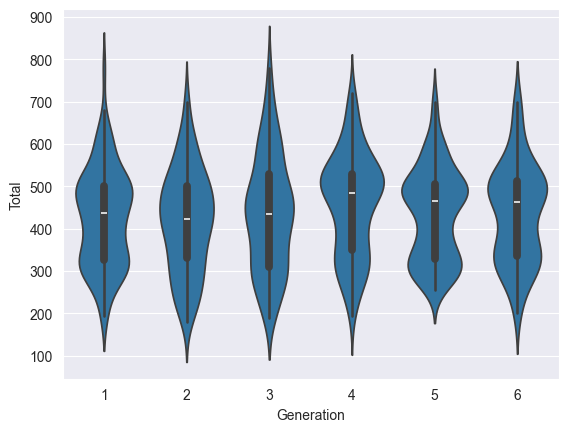

In [959]:
sns.violinplot(data=class_df, x='Generation', y='Total')

<Axes: xlabel='Generation', ylabel='count'>

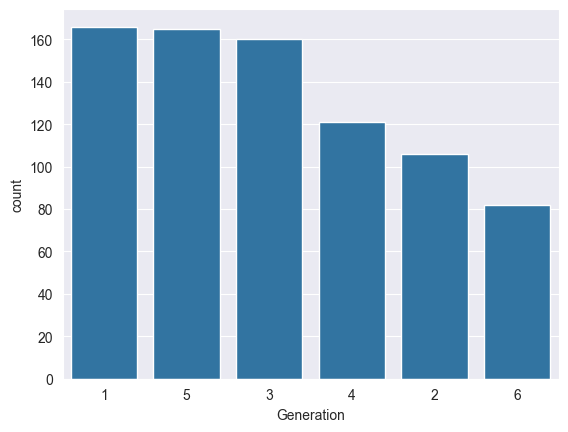

In [960]:
sns.countplot(x='Generation',
              data=class_df,
              order=class_df['Generation'].value_counts().index)

<Axes: xlabel='Legendary', ylabel='count'>

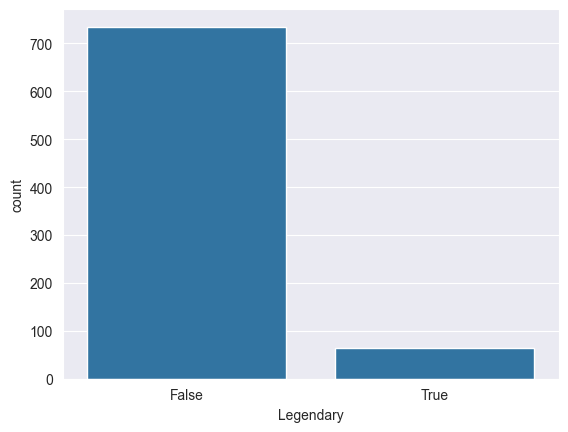

In [961]:
sns.countplot(x='Legendary',
              data=class_df,
              order=class_df['Legendary'].value_counts().index)

There are more pokemons from first generations.

<Axes: xlabel='Sp. Atk', ylabel='Sp. Def'>

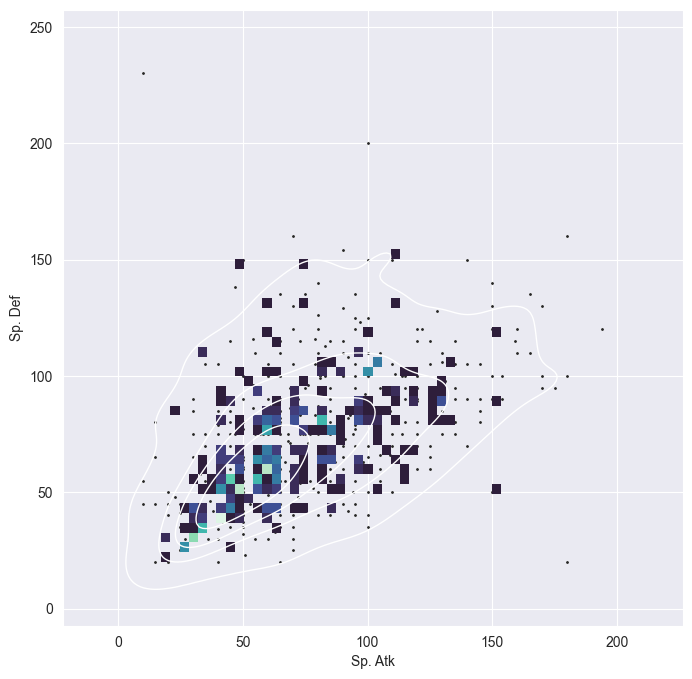

In [962]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=class_df['Sp. Atk'], y=class_df['Sp. Def'], s=5, color=".15")
sns.histplot(x=class_df['Sp. Atk'], y=class_df['Sp. Def'], bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=class_df['Sp. Atk'], y=class_df['Sp. Def'], levels=5, color="w", linewidths=1)

From this graph, we can see that most pokemon have sp. attack from 25 to 125 and sp. def from 20 to 120 but there is no pokemon with both high special attack and special defence, there must be a trade off. 

<Axes: xlabel='Attack', ylabel='Defense'>

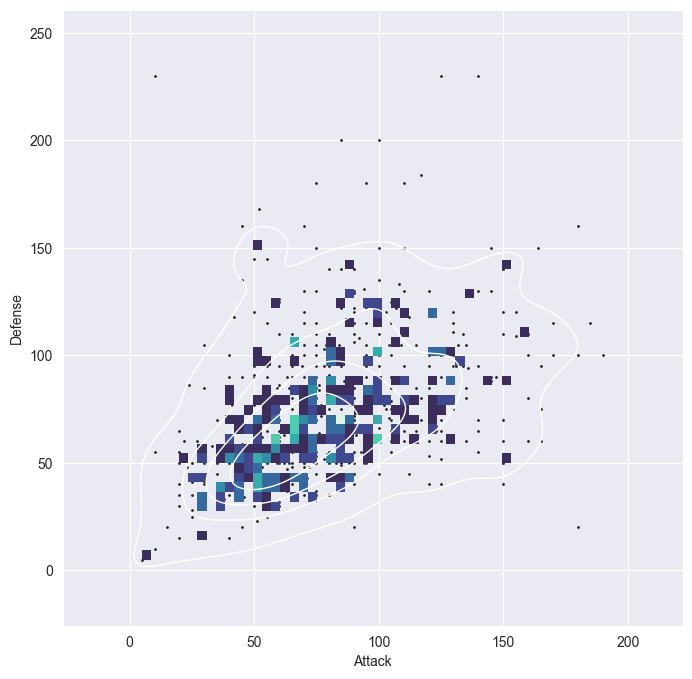

In [963]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=class_df['Attack'], y=class_df['Defense'], s=5, color=".15")
sns.histplot(x=class_df['Attack'], y=class_df['Defense'], bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=class_df['Attack'], y=class_df['Defense'], levels=5, color="w", linewidths=1)

The same dynamics can be seen with Attack and Defense.

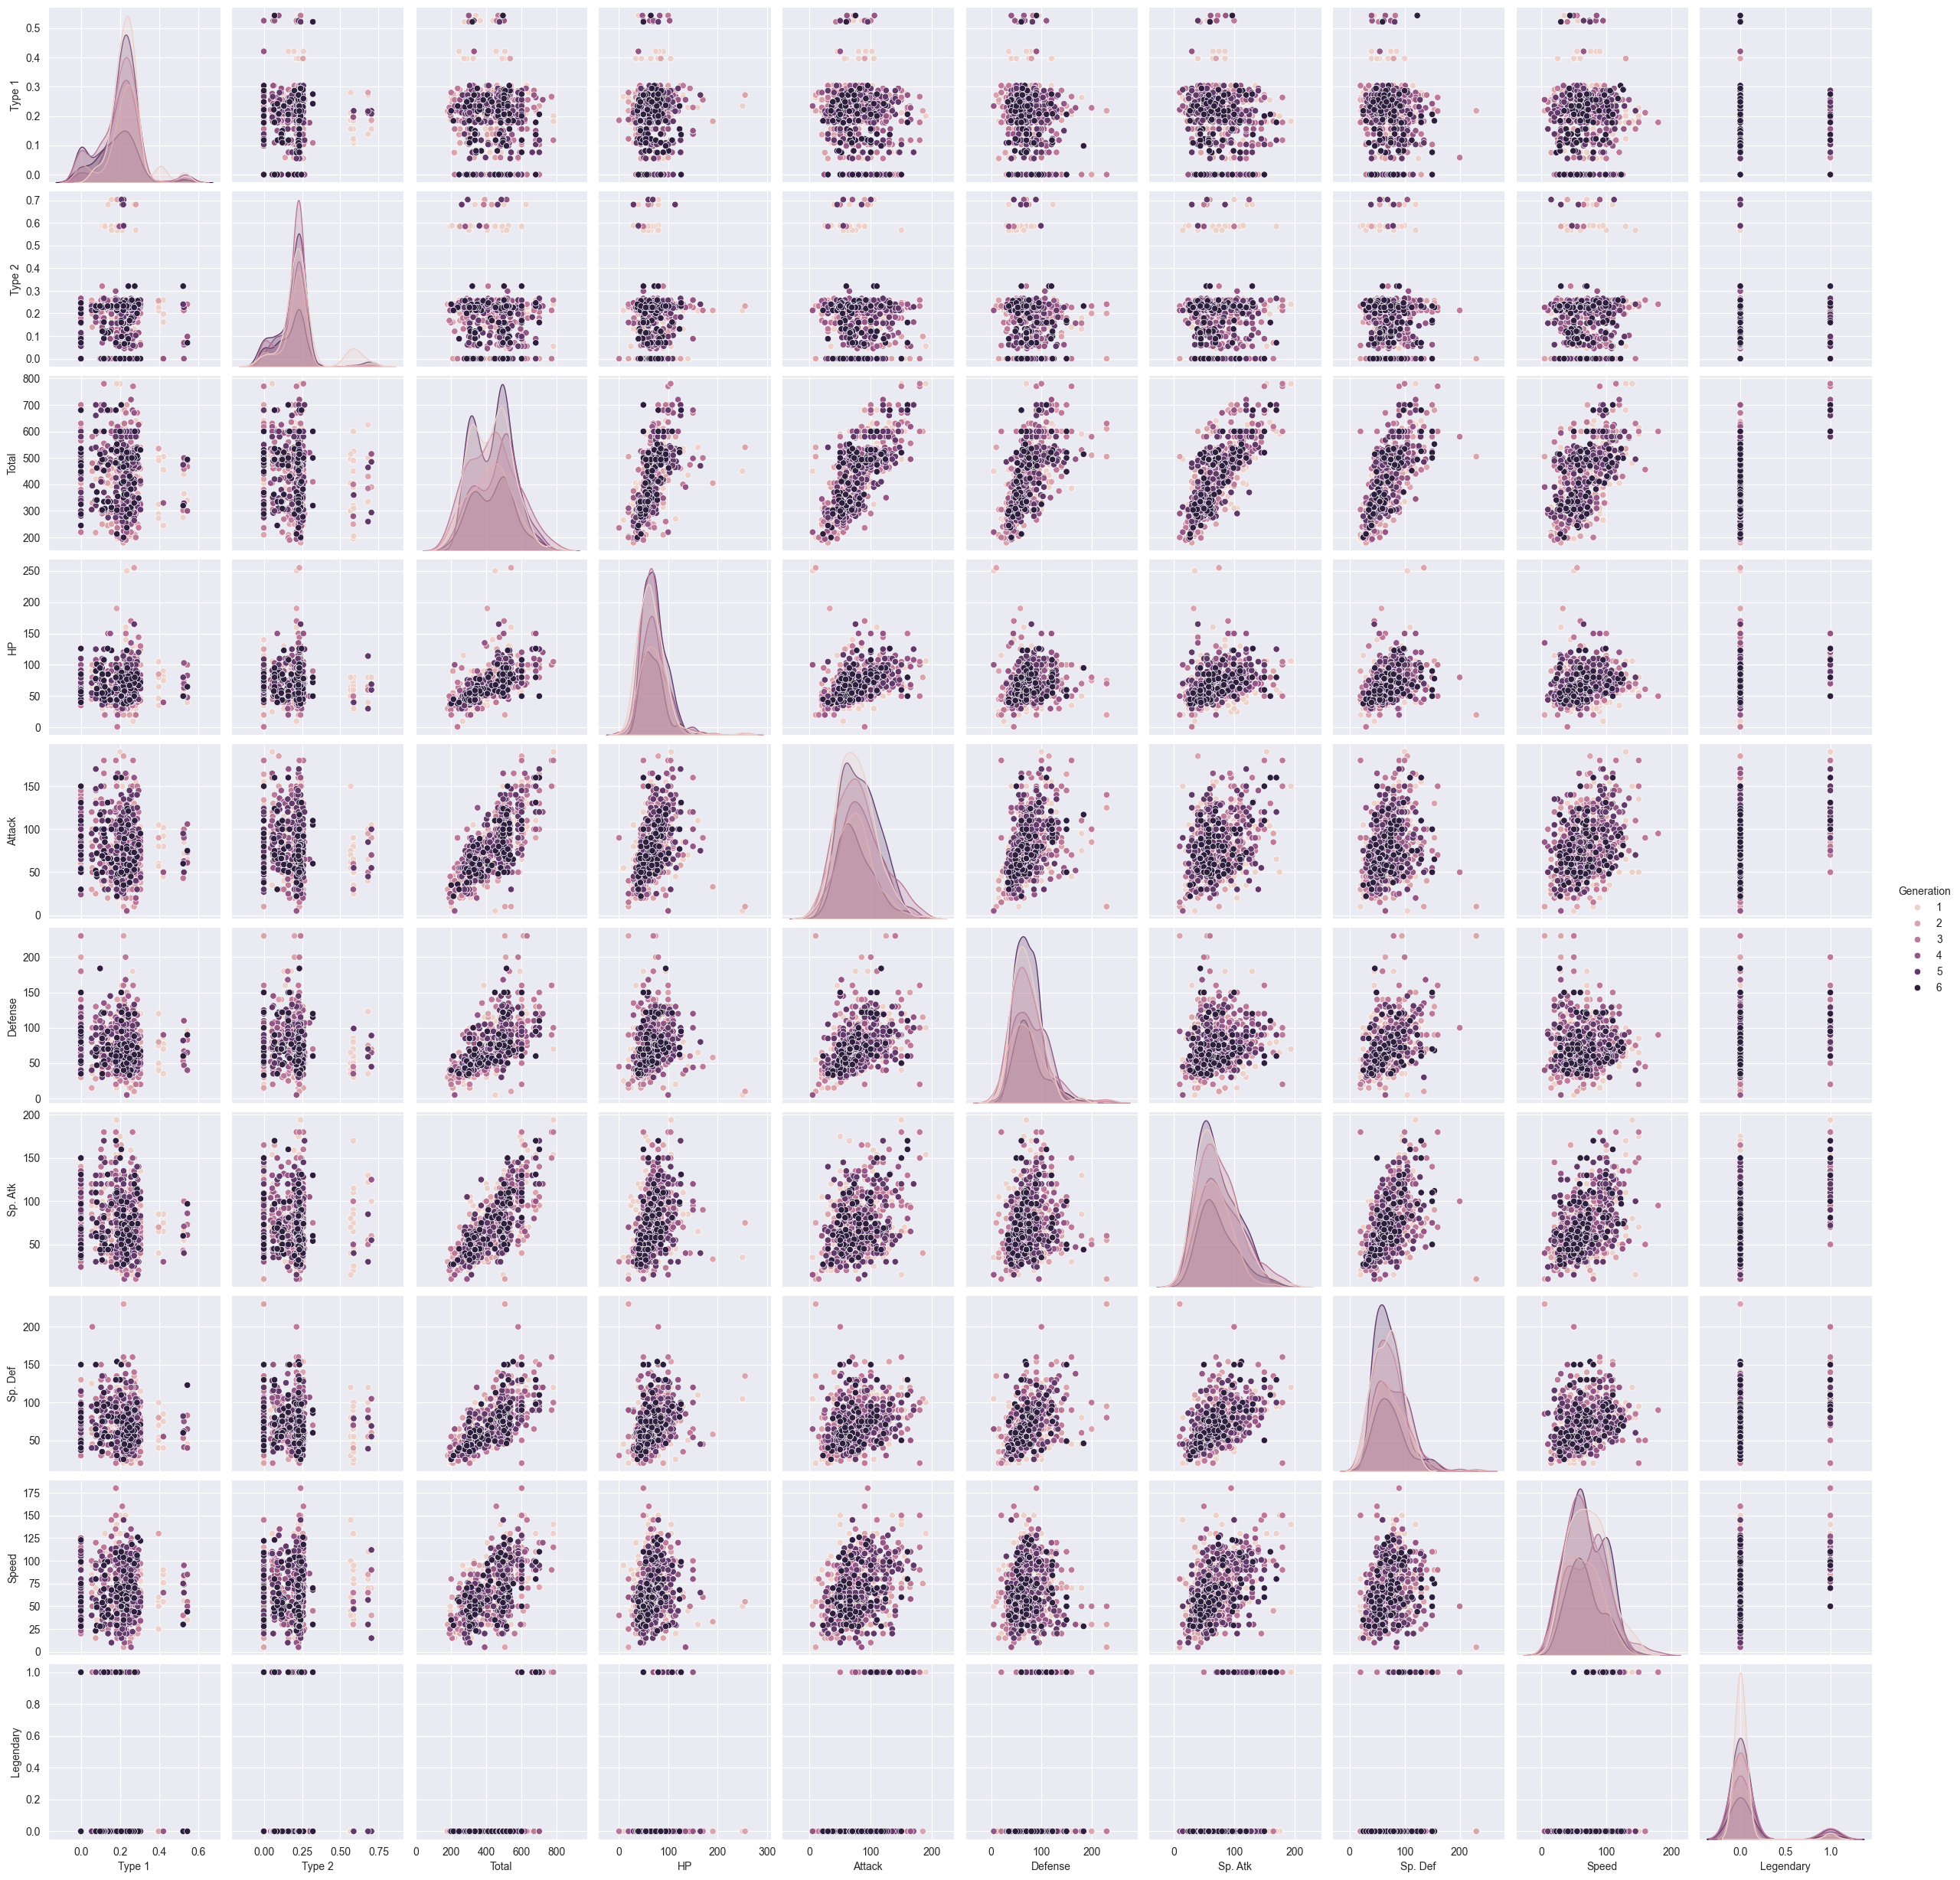

In [38]:
sns.pairplot(data=class_df, hue="Generation")

In [965]:
X = class_df[['Sp. Atk', 'Sp. Def', 'Attack', 'Speed', 'Type 1', 'Type 2', 'HP', 'Total']]
y = class_df['Legendary']

#### Feature selection
##### Pearson’s correlation selector

In [966]:
r_regression(X, y)

array([ 0.44890726,  0.36393712,  0.34540798,  0.32671529, -0.01016232,
        0.01067431,  0.27361956,  0.50175838])

Judging by this, we can see the top 3 features are Total, Special Attack and Special Defense.
#### Point-Biserial Correlation


In [967]:
[float(pointbiserialr(X[column], (y == 0).astype(int))[1]) for column in X.columns]

[6.31491577042715e-41,
 1.8439809580410317e-26,
 7.827253003205866e-24,
 2.3540754436896767e-21,
 0.7741185181969238,
 0.7630700955641351,
 3.3306476848463273e-15,
 3.095245746965573e-52]

By Point Biseral correlation, the 3 most impactful features are Attack, Type 1 and Type 2.
### Training models
Next we will try to train 2 models for each column sets and we will see which one are better and go further. I've chosen Logistic Regression and Bernoulli Naive Bayes. 
#### Training with Pearson's features

In [968]:
X_train, X_test, y_train, y_test = train_test_split(class_df[['Sp. Atk', 'Sp. Def', 'Total']],
                                                    class_df['Legendary'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       298
        True       0.62      0.59      0.60        22

    accuracy                           0.95       320
   macro avg       0.79      0.78      0.79       320
weighted avg       0.95      0.95      0.95       320



In [969]:
bb = BernoulliNB()
bb.fit(X_train, y_train)
predicted = bb.predict(X_test)
report = classification_report(y_test, predicted)
print(report)


              precision    recall  f1-score   support

       False       0.93      1.00      0.96       298
        True       0.00      0.00      0.00        22

    accuracy                           0.93       320
   macro avg       0.47      0.50      0.48       320
weighted avg       0.87      0.93      0.90       320



C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

#### Point Biseral correlation


In [970]:
X_train, X_test, y_train, y_test = train_test_split(class_df[['Attack', 'Type 1', 'Type 2']],
                                                    class_df['Legendary'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

       False       0.94      0.99      0.97       298
        True       0.60      0.14      0.22        22

    accuracy                           0.93       320
   macro avg       0.77      0.56      0.59       320
weighted avg       0.92      0.93      0.91       320



In [971]:
bb = BernoulliNB()
bb.fit(X_train, y_train)
predicted = bb.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

       False       0.93      1.00      0.96       298
        True       0.00      0.00      0.00        22

    accuracy                           0.93       320
   macro avg       0.47      0.50      0.48       320
weighted avg       0.87      0.93      0.90       320



C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

The best behaving model here is LogisticRegression with features selected through Pearson classification algorithm, so we will go further with this model.
### Class balancing
Our data is pretty imbalanced, as there are less legendary pokemons than casual.
#### class_weight='balanced'
Firstly, let's try balanced parameter of our model and check if there are any improvements.

In [972]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(class_df[['Sp. Atk', 'Sp. Def', 'Total']],
                                                    class_df['Legendary'],
                                                    test_size=0.2,
                                                    random_state=42)
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.93      0.97       298
        True       0.52      1.00      0.69        22

    accuracy                           0.94       320
   macro avg       0.76      0.97      0.83       320
weighted avg       0.97      0.94      0.95       320



The f1 score got lower but that isn't necessarily bad.
#### Undersampling


In [973]:
undersampler = RandomUnderSampler()
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

lr_under = LogisticRegression()
lr_under.fit(X_train_under, y_train_under)
predicted_under = lr_under.predict(X_test)
report_under = classification_report(y_test, predicted_under)
print("Classification Report with Undersampling:")
print(report_under)

Classification Report with Undersampling:
              precision    recall  f1-score   support

       False       1.00      0.87      0.93       298
        True       0.36      1.00      0.53        22

    accuracy                           0.88       320
   macro avg       0.68      0.93      0.73       320
weighted avg       0.96      0.88      0.90       320



#### Oversampling(SMOTE)

In [974]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression()
lr_smote.fit(X_train_smote, y_train_smote)
predicted_smote = lr_smote.predict(X_test)
report_smote = classification_report(y_test, predicted_smote)
print("Classification Report with SMOTE:")
print(report_smote)

Classification Report with SMOTE:
              precision    recall  f1-score   support

       False       1.00      0.93      0.97       298
        True       0.52      1.00      0.69        22

    accuracy                           0.94       320
   macro avg       0.76      0.97      0.83       320
weighted avg       0.97      0.94      0.95       320



I see an improvement in classifying truths going from 0.60 to 0.69 but I all models class balancing behaves the same. The recall improvement is also huge going from 0.59 to 1.0 while precision is decreasing 0.6 to 0.5. Accuracy hasn't change that much, it mostly stayed the same after class balancing.

#### But can we improve further?
Let's use grid search in order to see if we can improve furthermore. 

In [975]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_smote, y_train_smote)

# Make predictions using the best model from grid search
predicted = grid_search.best_estimator_.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.93      0.96       298
        True       0.51      1.00      0.68        22

    accuracy                           0.93       320
   macro avg       0.76      0.96      0.82       320
weighted avg       0.97      0.93      0.94       320



Somehow, we got worse accuracy, precision and recall, I guess we can't approve further.
#### Lime

In [976]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=['Sp. Atk', 'Sp. Def', 'Total'],
    class_names=['Not Legendary', 'Legendary'],
    discretize_continuous=True
)

idx = np.random.randint(0, X_test.shape[0])
instance = X_test.iloc[idx]

explanation = explainer.explain_instance(instance.values, lr.predict_proba)

explanation.show_in_notebook()

C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


For the random case it selected, we see that Total has a great impact towards 'Not Legendary' status while other features we selected are barely impacting the result.
## Used car data

In [977]:
car_df.head()

Unnamed: 0  Id  year          brand  \
0           0   0  2016          Honda   
1           1   1  2012         Nissan   
2           2   2  2017         Toyota   
3           3   3  2017  Mercedes-Benz   
4           4   4  2012        Hyundai   

                                     full_model_name model_name      price  \
0                                    Honda Brio S MT       Brio   425000.0   
1                             Nissan Sunny XV Diesel      Sunny   325000.0   
2             Toyota Fortuner 2.8 4x2 MT [2016-2020]   Fortuner  2650000.0   
3  Mercedes-Benz E-Class E 220d Expression [2019-...    E-Class  4195000.0   
4                  Hyundai Verna Fluidic 1.6 CRDi SX      Verna   475000.0   

   distance_travelled(kms) fuel_type    city  ...  new and less used  \
0                   9680.0    Petrol  Mumbai  ...                  0   
1                 119120.0    Diesel  Mumbai  ...                  0   
2                  64593.0    Diesel   Thane  ...                  0   
3                  25000.0    Diesel  Mumbai  ...                  1   
4                  23800.0    Diesel  Mumbai  ...                  0   

   inv_car_price  inv_car_dist  inv_car_age  inv_brand  std_invprice  \
0   2.352941e-06      0.000103     0.200000   0.142857      0.143417   
1   3.076923e-06      0.000008     0.111111   0.090909      0.188859   
2   3.773585e-07      0.000015     0.250000   1.000000      0.019416   
3   2.383790e-07      0.000040     0.250000   0.500000      0.010692   
4   2.105263e-06      0.000042     0.111111   0.071429      0.127871   

   std_invdistance_travelled  std_invrank   best_buy1  best_buy2  
0                   0.035730     0.132143  677.134239   0.000000  
1                   0.002496     0.079545   37.501318   0.000000  
2                   0.004978     1.000000   96.646020   0.000000  
3                   0.013563     0.493750   71.604306  71.604306  
4                   0.014269     0.059821  109.150857   0.000000  

[5 rows x 23 columns]

This data consists of 10 columns, importantly consisting of car data : build year, company name, full model name, model name, price of sale, kms driven, fuel type and city in which it is available with extra features added in it.




In [978]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1725 non-null   int64  
 1   Id                         1725 non-null   int64  
 2   year                       1725 non-null   int64  
 3   brand                      1725 non-null   object 
 4   full_model_name            1725 non-null   object 
 5   model_name                 1725 non-null   object 
 6   price                      1725 non-null   float64
 7   distance_travelled(kms)    1725 non-null   float64
 8   fuel_type                  1725 non-null   object 
 9   city                       1725 non-null   object 
 10  brand_rank                 1725 non-null   int64  
 11  car_age                    1725 non-null   float64
 12  distance below 30k km      1725 non-null   int64  
 13  new and less used          1725 non-null   int64

We have mostly numeric types but few string fields that we will need to convert: brand, full_model_name, model_name, fuel_type and city. Also, lucky for us, there aren't any missing values in any of columns.

In [979]:
car_df.describe()

C:\Users\Octavian\PycharmProjects\sigmoid-tasks\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Unnamed: 0           Id         year         price  \
count  1725.000000  1725.000000  1725.000000  1.725000e+03   
mean    862.000000   862.000000  2015.390725  1.494837e+06   
std     498.108924   498.108924     3.207504  1.671658e+06   
min       0.000000     0.000000  1990.000000  6.250000e+04   
25%     431.000000   431.000000  2013.000000  5.450000e+05   
50%     862.000000   862.000000  2016.000000  8.750000e+05   
75%    1293.000000  1293.000000  2018.000000  1.825000e+06   
max    1724.000000  1724.000000  2021.000000  1.470000e+07   

       distance_travelled(kms)   brand_rank      car_age  \
count              1725.000000  1725.000000  1725.000000   
mean              53848.256232    15.731014     5.609275   
std               44725.541963    12.951122     3.207504   
min                 350.000000     1.000000     0.000000   
25%               29000.000000     5.000000     3.000000   
50%               49000.000000    14.000000     5.000000   
75%               70500.000000    24.000000     8.000000   
max              790000.000000    81.000000    31.000000   

       distance below 30k km  new and less used  inv_car_price  inv_car_dist  \
count            1725.000000        1725.000000   1.725000e+03   1725.000000   
mean                0.269565           0.209275   1.416237e-06      0.000041   
std                 0.443863           0.406909   1.291449e-06      0.000110   
min                 0.000000           0.000000   6.802721e-08      0.000001   
25%                 0.000000           0.000000   5.479452e-07      0.000014   
50%                 0.000000           0.000000   1.142857e-06      0.000020   
75%                 1.000000           0.000000   1.834862e-06      0.000034   
max                 1.000000           1.000000   1.600000e-05      0.002857   

       inv_car_age    inv_brand  std_invprice  std_invdistance_travelled  \
count  1725.000000  1725.000000   1725.000000                1725.000000   
mean           inf     0.187810      0.084623                   0.013809   
std            NaN     0.254849      0.081060                   0.038689   
min       0.032258     0.012346      0.000000                   0.000000   
25%       0.125000     0.041667      0.030123                   0.004524   
50%       0.200000     0.071429      0.067464                   0.006703   
75%       0.333333     0.200000      0.110899                   0.011631   
max            inf     1.000000      1.000000                   1.000000   

       std_invrank    best_buy1    best_buy2  
count  1725.000000  1725.000000  1725.000000  
mean      0.177658    88.962902    32.537208  
std       0.258034   188.950690   158.662274  
min       0.000000     0.000000     0.000000  
25%       0.029687    14.237358     0.000000  
50%       0.059821    36.716166     0.000000  
75%       0.190000    90.776658     0.000000  
max       1.000000  2477.517640  2477.517640

In [980]:
car_df.isin([np.inf]).sum()

Unnamed: 0                    0
Id                            0
year                          0
brand                         0
full_model_name               0
model_name                    0
price                         0
distance_travelled(kms)       0
fuel_type                     0
city                          0
brand_rank                    0
car_age                       0
distance below 30k km         0
new and less used             0
inv_car_price                 0
inv_car_dist                  0
inv_car_age                  21
inv_brand                     0
std_invprice                  0
std_invdistance_travelled     0
std_invrank                   0
best_buy1                     0
best_buy2                     0
dtype: int64

In [981]:
## Let's replace inf 
car_df.replace(to_replace=np.inf, value=-1, inplace=True)
car_df.isin([np.inf]).sum()

Unnamed: 0                   0
Id                           0
year                         0
brand                        0
full_model_name              0
model_name                   0
price                        0
distance_travelled(kms)      0
fuel_type                    0
city                         0
brand_rank                   0
car_age                      0
distance below 30k km        0
new and less used            0
inv_car_price                0
inv_car_dist                 0
inv_car_age                  0
inv_brand                    0
std_invprice                 0
std_invdistance_travelled    0
std_invrank                  0
best_buy1                    0
best_buy2                    0
dtype: int64

We will make a model that will guess price based on few parameters.
### Data preprocessing 
We will need to drop first, id, model name and full model name. Also I think that brand will also be irrelevant as we have brand rank and if we will try to do label encoding we will get the same kindoff column.

In [982]:
[car_df.drop(column, axis='columns', inplace=True) for column in
 ['Unnamed: 0', 'Id', 'model_name', 'full_model_name', 'brand']]
car_df.head()

year      price  distance_travelled(kms) fuel_type    city  brand_rank  \
0  2016   425000.0                   9680.0    Petrol  Mumbai           7   
1  2012   325000.0                 119120.0    Diesel  Mumbai          11   
2  2017  2650000.0                  64593.0    Diesel   Thane           1   
3  2017  4195000.0                  25000.0    Diesel  Mumbai           2   
4  2012   475000.0                  23800.0    Diesel  Mumbai          14   

   car_age  distance below 30k km  new and less used  inv_car_price  \
0      5.0                      1                  0   2.352941e-06   
1      9.0                      0                  0   3.076923e-06   
2      4.0                      0                  0   3.773585e-07   
3      4.0                      1                  1   2.383790e-07   
4      9.0                      1                  0   2.105263e-06   

   inv_car_dist  inv_car_age  inv_brand  std_invprice  \
0      0.000103     0.200000   0.142857      0.143417   
1      0.000008     0.111111   0.090909      0.188859   
2      0.000015     0.250000   1.000000      0.019416   
3      0.000040     0.250000   0.500000      0.010692   
4      0.000042     0.111111   0.071429      0.127871   

   std_invdistance_travelled  std_invrank   best_buy1  best_buy2  
0                   0.035730     0.132143  677.134239   0.000000  
1                   0.002496     0.079545   37.501318   0.000000  
2                   0.004978     1.000000   96.646020   0.000000  
3                   0.013563     0.493750   71.604306  71.604306  
4                   0.014269     0.059821  109.150857   0.000000

Next, we will label encode city column.

In [983]:
label_encoder = LabelEncoder()
car_df['city'] = label_encoder.fit_transform(car_df['city'])
car_df.head()

year      price  distance_travelled(kms) fuel_type  city  brand_rank  \
0  2016   425000.0                   9680.0    Petrol     9           7   
1  2012   325000.0                 119120.0    Diesel     9          11   
2  2017  2650000.0                  64593.0    Diesel    14           1   
3  2017  4195000.0                  25000.0    Diesel     9           2   
4  2012   475000.0                  23800.0    Diesel     9          14   

   car_age  distance below 30k km  new and less used  inv_car_price  \
0      5.0                      1                  0   2.352941e-06   
1      9.0                      0                  0   3.076923e-06   
2      4.0                      0                  0   3.773585e-07   
3      4.0                      1                  1   2.383790e-07   
4      9.0                      1                  0   2.105263e-06   

   inv_car_dist  inv_car_age  inv_brand  std_invprice  \
0      0.000103     0.200000   0.142857      0.143417   
1      0.000008     0.111111   0.090909      0.188859   
2      0.000015     0.250000   1.000000      0.019416   
3      0.000040     0.250000   0.500000      0.010692   
4      0.000042     0.111111   0.071429      0.127871   

   std_invdistance_travelled  std_invrank   best_buy1  best_buy2  
0                   0.035730     0.132143  677.134239   0.000000  
1                   0.002496     0.079545   37.501318   0.000000  
2                   0.004978     1.000000   96.646020   0.000000  
3                   0.013563     0.493750   71.604306  71.604306  
4                   0.014269     0.059821  109.150857   0.000000

In [984]:
list(enumerate(label_encoder.classes_))

[(0, 'Agra'),
 (1, 'Bangalore'),
 (2, 'Chennai'),
 (3, 'Dehradun'),
 (4, 'Delhi'),
 (5, 'Faridabad'),
 (6, 'Ghaziabad'),
 (7, 'Hyderabad'),
 (8, 'Lucknow'),
 (9, 'Mumbai'),
 (10, 'Navi Mumbai'),
 (11, 'Noida'),
 (12, 'Panchkula'),
 (13, 'Pune'),
 (14, 'Thane')]

Next, we will encode fuel_type.

In [985]:
car_df['fuel_type'].unique()

array(['Petrol', 'Diesel', 'Petrol + 1', 'CNG + 1', 'Hybrid'],
      dtype=object)

 I expect that most of our data is mostly Petrol or Diesel so I will try to OneHotEncode this column with only these 2 values. But first let's reassure us that these columns are the majority. 

<Axes: xlabel='fuel_type', ylabel='count'>

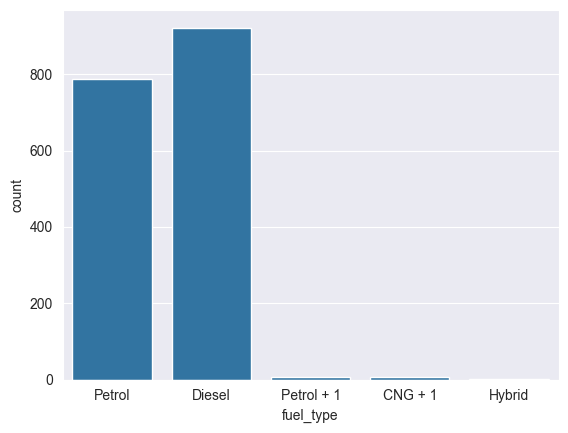

In [986]:
sns.countplot(x='fuel_type', data=car_df)

As expected, alternative fuel types aren't as popular, we can neglect them.

In [987]:
encoder = OneHotEncoder(categories=[['Petrol', 'Diesel']], handle_unknown='ignore')
encoded = encoder.fit_transform(car_df[['fuel_type']])
data_encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['fuel_type']))
car_df = pd.concat([car_df.drop(columns=['fuel_type']), data_encoded], axis=1)
car_df.head()

year      price  distance_travelled(kms)  city  brand_rank  car_age  \
0  2016   425000.0                   9680.0     9           7      5.0   
1  2012   325000.0                 119120.0     9          11      9.0   
2  2017  2650000.0                  64593.0    14           1      4.0   
3  2017  4195000.0                  25000.0     9           2      4.0   
4  2012   475000.0                  23800.0     9          14      9.0   

   distance below 30k km  new and less used  inv_car_price  inv_car_dist  \
0                      1                  0   2.352941e-06      0.000103   
1                      0                  0   3.076923e-06      0.000008   
2                      0                  0   3.773585e-07      0.000015   
3                      1                  1   2.383790e-07      0.000040   
4                      1                  0   2.105263e-06      0.000042   

   inv_car_age  inv_brand  std_invprice  std_invdistance_travelled  \
0     0.200000   0.142857      0.143417                   0.035730   
1     0.111111   0.090909      0.188859                   0.002496   
2     0.250000   1.000000      0.019416                   0.004978   
3     0.250000   0.500000      0.010692                   0.013563   
4     0.111111   0.071429      0.127871                   0.014269   

   std_invrank   best_buy1  best_buy2  fuel_type_Petrol  fuel_type_Diesel  
0     0.132143  677.134239   0.000000               1.0               0.0  
1     0.079545   37.501318   0.000000               0.0               1.0  
2     1.000000   96.646020   0.000000               0.0               1.0  
3     0.493750   71.604306  71.604306               0.0               1.0  
4     0.059821  109.150857   0.000000               0.0               1.0

### Data analysis

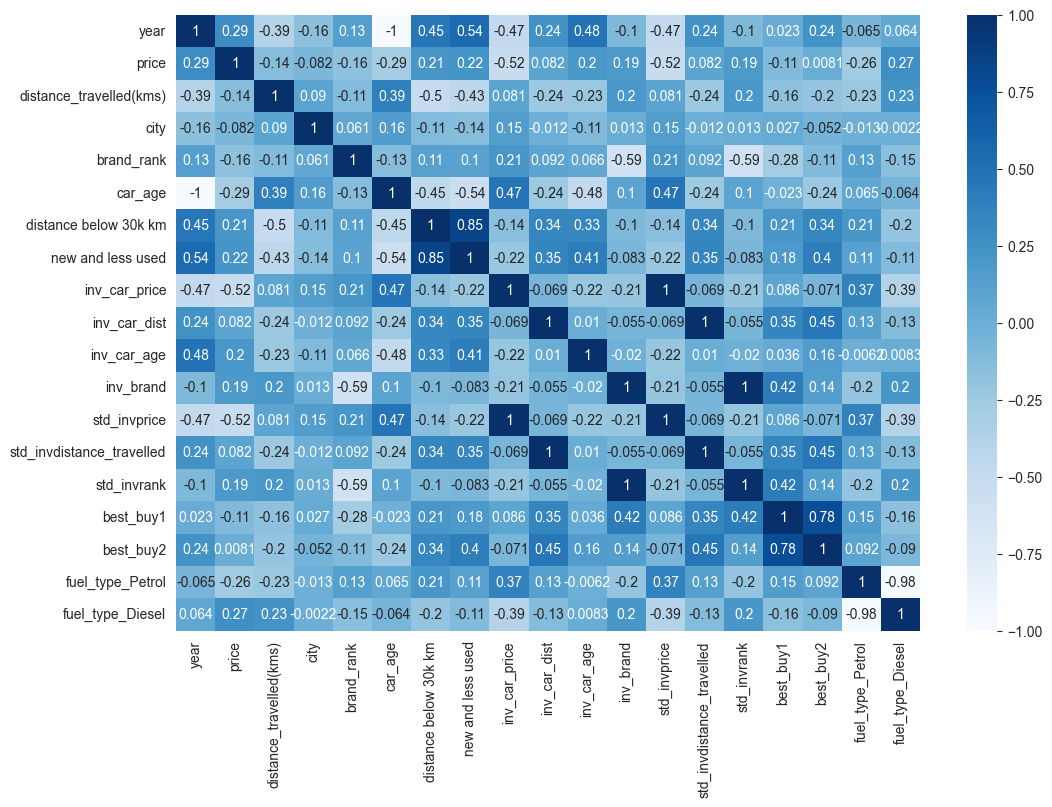

In [988]:
plt.figure(figsize=(12, 8))
sns.heatmap(car_df.corr(), annot=True, cmap=plt.cm.Blues);
plt.show()

Price has most correlation with new and less used, car age and fuel_type_Diesel. Year and car age basically have the same correlation since they represent the same information, we probably should one of the columns. I would prefer to not use inverted values.

In [989]:
car_df.drop('car_age', axis=1, inplace=True)

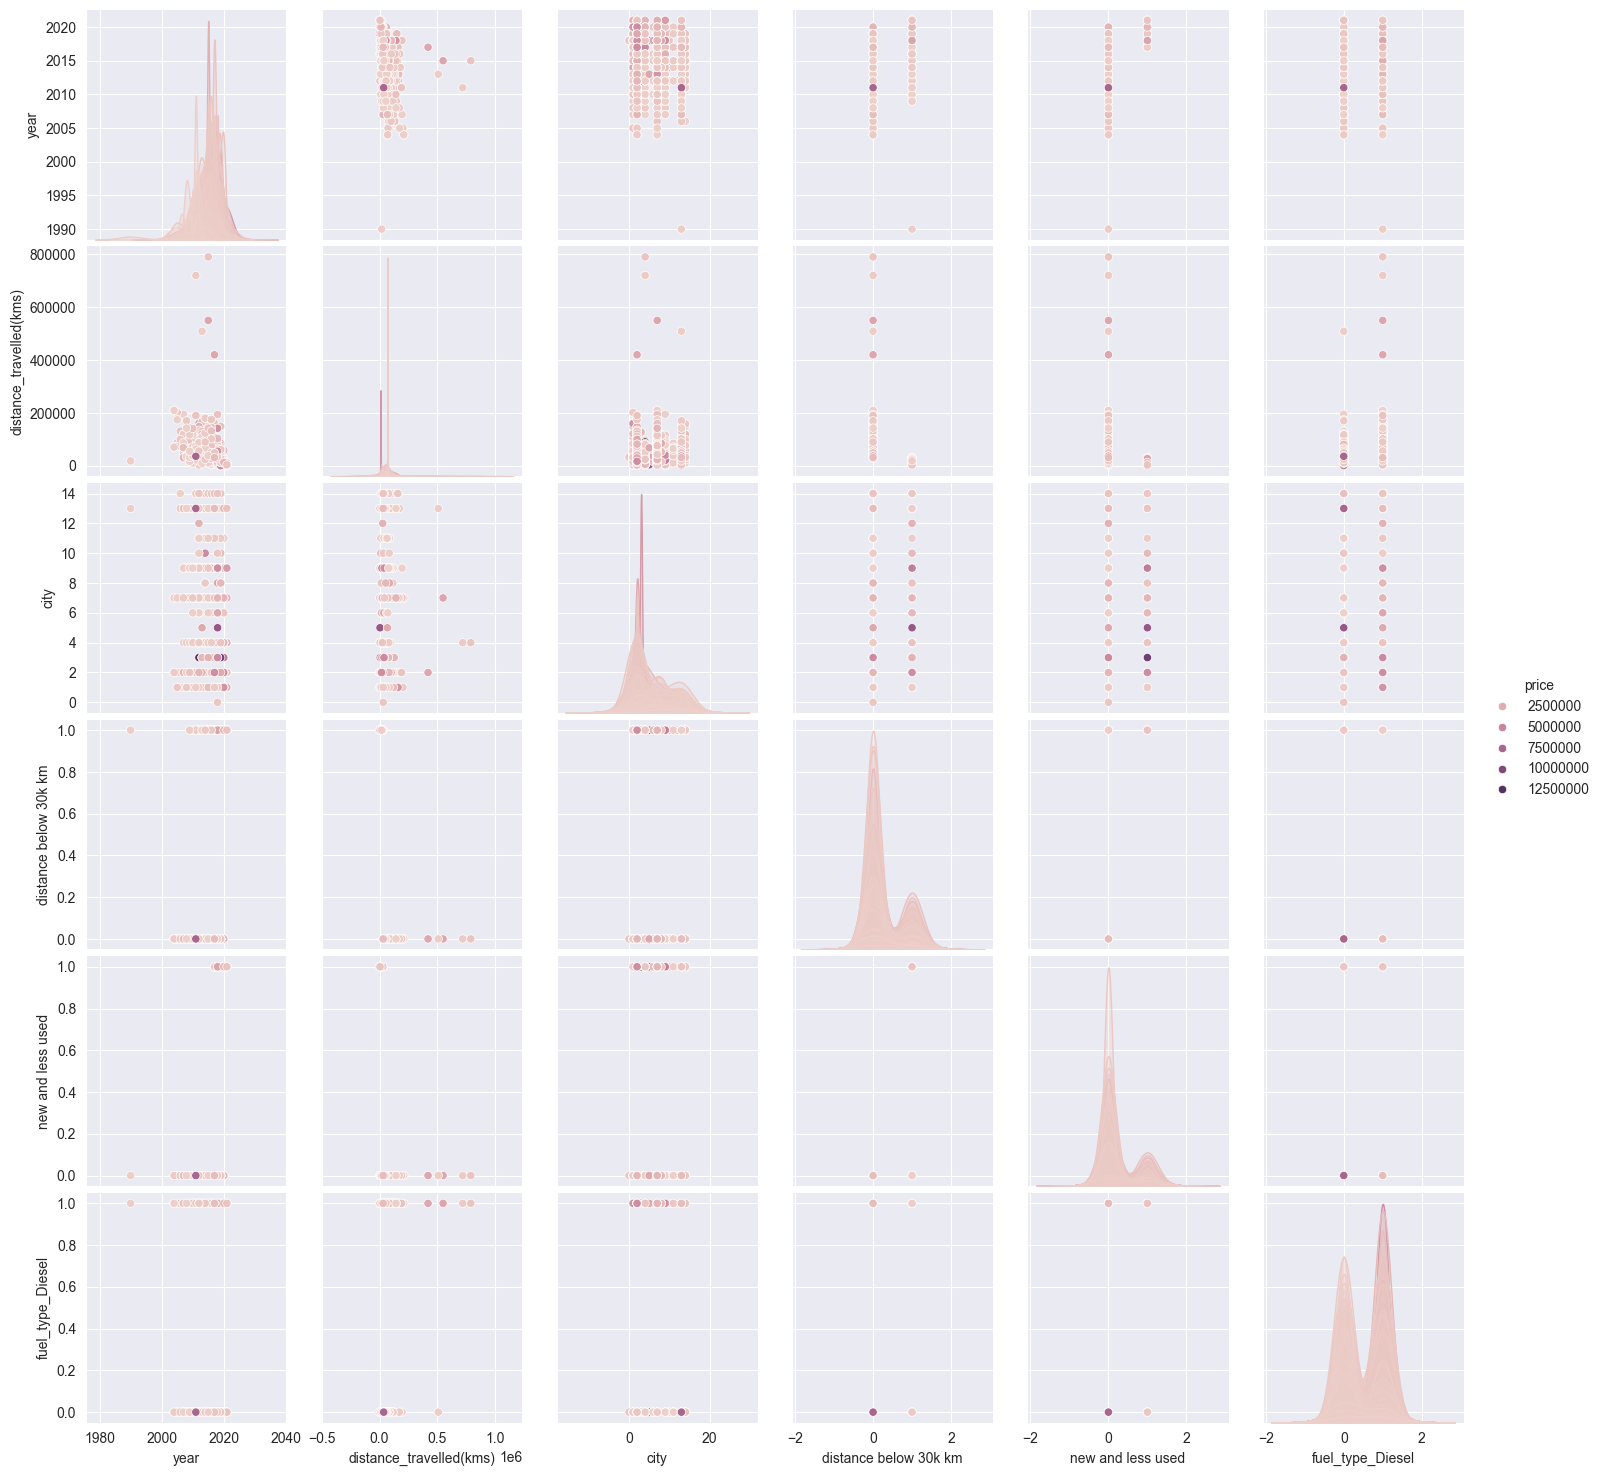

In [990]:
sns.pairplot(data=car_df,
             vars=['year', 'distance_travelled(kms)', 'city', 'distance below 30k km', 'new and less used', 'fuel_type_Diesel'], hue="price")

There seems to be a city with a very high number of cars. Let's see which it is.

<Axes: xlabel='city', ylabel='count'>

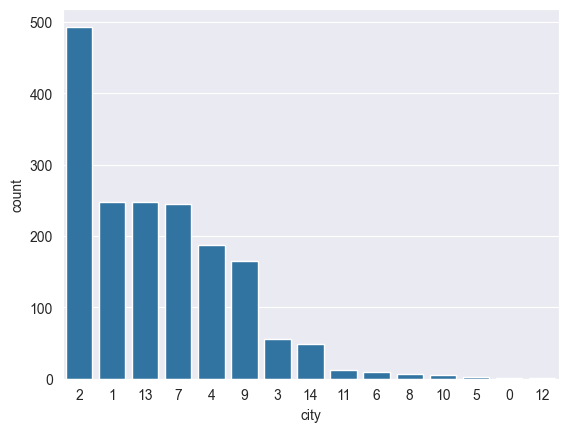

In [991]:
sns.countplot(x='city',
              data=car_df,
              order=car_df['city'].value_counts().index)


Somehow, most cars from our dataset are sold in Chennai, which has more cars then several cities combined. This might add bias to our model.

<Axes: xlabel='price', ylabel='Density'>

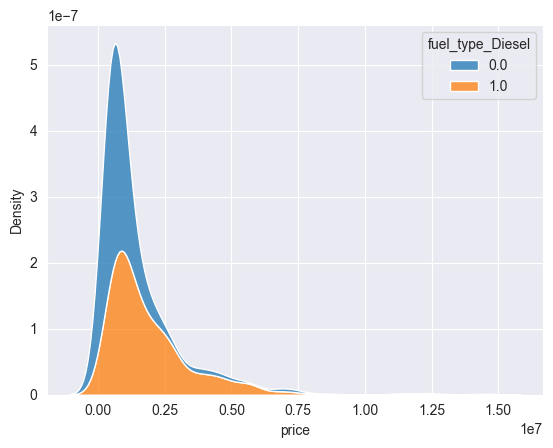

In [992]:
sns.kdeplot(data=car_df, x="price", hue="fuel_type_Diesel", multiple="stack")

<Axes: xlabel='price', ylabel='Density'>

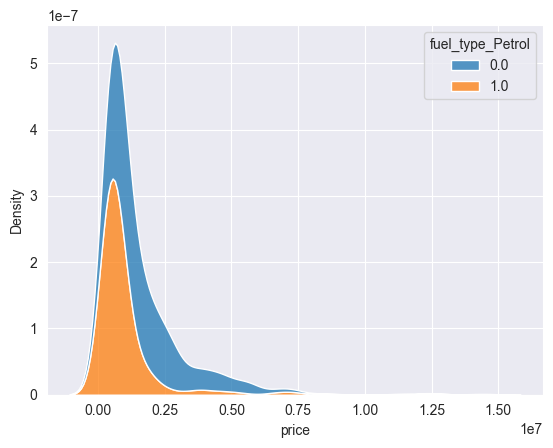

In [993]:
sns.kdeplot(data=car_df, x="price", hue="fuel_type_Petrol", multiple="stack")

There are cheaper petrol options than diesel and diesel options are way less.

<Axes: xlabel='year', ylabel='price'>

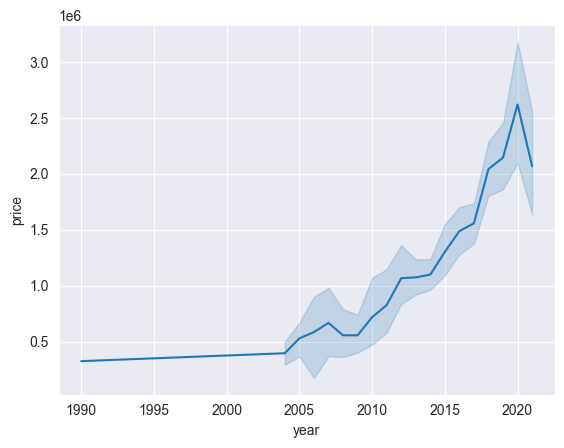

In [994]:
sns.lineplot(data=car_df, x="year", y="price")

As expected, newer cars are way expensive, except 2015-2020 which experience a little downfall.

<Axes: xlabel='new and less used', ylabel='price'>

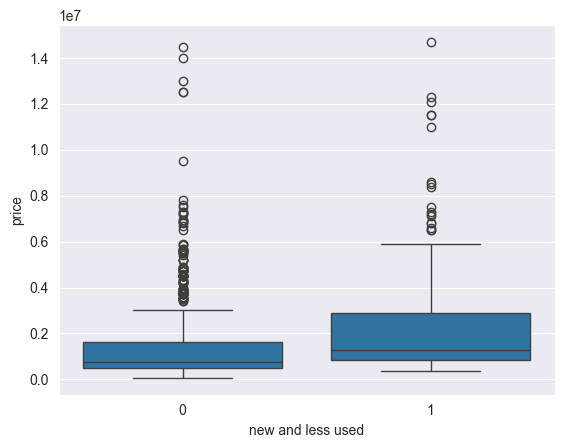

In [995]:
sns.boxplot(data=car_df, x="new and less used", y="price")

Same dynamics here, new cars are usually pricer and we have many outliers.

In [996]:
X = car_df[['year', 'distance_travelled(kms)', 'city', 'brand_rank',
            'distance below 30k km', 'new and less used', 'best_buy1', 'best_buy2',
            'fuel_type_Petrol', 'fuel_type_Diesel']]
y = car_df['price']

### Feature selection
In this study, P-value-based feature selection and LASSO algorithms will be used for feature selection.
#### P-value-based feature selection


In [997]:
pvalue_selector = PValueSelector()
selected_columns = pvalue_selector.select(car_df, 'price')
selected_columns

['distance_travelled(kms)',
 'brand_rank',
 'distance below 30k km',
 'new and less used',
 'inv_car_price',
 'inv_car_dist',
 'inv_car_age',
 'inv_brand',
 'std_invprice',
 'std_invdistance_travelled',
 'std_invrank',
 'best_buy1',
 'best_buy2',
 'fuel_type_Diesel']

Let's set a lower significance level, to get less features. 

In [998]:
pvalue_selector = PValueSelector(significance_level=0.0000005)
selected_columns = pvalue_selector.select(car_df, 'price')
selected_columns

['distance below 30k km',
 'inv_car_price',
 'inv_brand',
 'std_invprice',
 'std_invrank',
 'best_buy1']

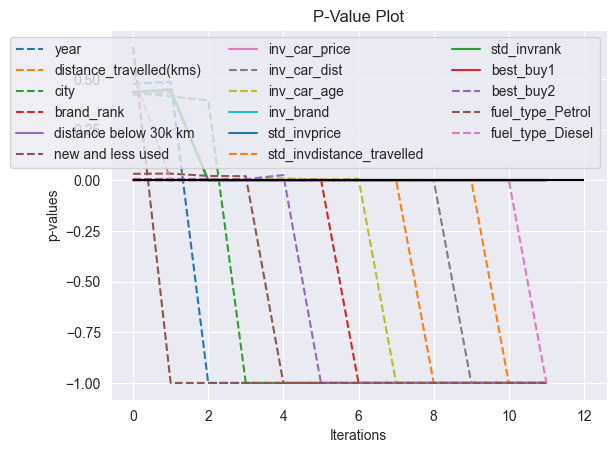

In [999]:
pvalue_selector.plot_process()

#### Lasso

In [1000]:
lasso = LassoSelector()
selected_columns = lasso.select(car_df, 'price')
selected_columns

['year',
 'distance_travelled(kms)',
 'city',
 'brand_rank',
 'distance below 30k km',
 'new and less used',
 'inv_car_age',
 'inv_brand',
 'std_invprice',
 'std_invdistance_travelled',
 'std_invrank',
 'best_buy1',
 'best_buy2',
 'fuel_type_Petrol',
 'fuel_type_Diesel']

I will get only the first 3 features, from both algorithms and will train 2 models(Linear Regression and SVM) on each set of features.
#### PValueSelector

In [1001]:
X_train, X_test, y_train, y_test = train_test_split(car_df[['distance below 30k km', 'std_invrank',
                                                            'inv_brand']],
                                                    car_df['price'],
                                                    test_size=0.2,
                                                    random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
print('mse:', mean_squared_error(predicted, y_test))
print('mae:', mean_absolute_error(predicted, y_test))

mse: 2572094774612.3057
mae: 1015595.3425739087


#### Ridge


In [1002]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicted = ridge.predict(X_test)
print('mse:', mean_squared_error(predicted, y_test))
print('mae:', mean_absolute_error(predicted, y_test))

mse: 2572883225628.584
mae: 1015747.7860336119


We got similar results for both algorithms, now let's try with other features selected with Lasso algorithm.


In [1003]:
X_train, X_test, y_train, y_test = train_test_split(car_df[['year', 'distance_travelled(kms)', 'city']],
                                                    car_df['price'],
                                                    test_size=0.2,
                                                    random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
print('mse:', mean_squared_error(predicted, y_test))
print('mae:', mean_absolute_error(predicted, y_test))


mse: 2587605565676.716
mae: 1039721.5916997294


#### Support Vector Regression
Clearly, we got better results with features selected with PValueSelector. 

In [1004]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicted = ridge.predict(X_test)
print('mse:', mean_squared_error(predicted, y_test))
print('mae:', mean_absolute_error(predicted, y_test))

mse: 2587615976482.0034
mae: 1039721.9666607525


The best results we got with linear regression and pvalue selected feature with lowest mse and mae values, we will use it further.
### Let's try to tune it with GridSearchCV


In [1005]:
X_train, X_test, y_train, y_test = train_test_split(car_df[['distance below 30k km', 'std_invrank',
                                                            'inv_brand']],
                                                    car_df['price'],
                                                    test_size=0.2,
                                                    random_state=42)
param_grid = {'fit_intercept': [True, False],
              'positive': [True, False],
              'copy_X': [True, False],
              'n_jobs': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
lr = LinearRegression()
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [1006]:
lr = LinearRegression(**{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False})
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
print('mse:', mean_squared_error(predicted, y_test))
print('mae:', mean_absolute_error(predicted, y_test))


mse: 2572094774612.3057
mae: 1015595.3425739087


Our attempt to tune it further was clearly a failure, because we got the same results, so all we have left is to interpret our model further.


In [1007]:

# Create an explainer object using the linear regression model
explainer = shap.Explainer(lr.predict, X_train, )

# Get SHAP values for the test set
shap_values = explainer(X_test)

# Visualize the SHAP values for the first prediction
shap.initjs()
shap.force_plot(shap_values[0])

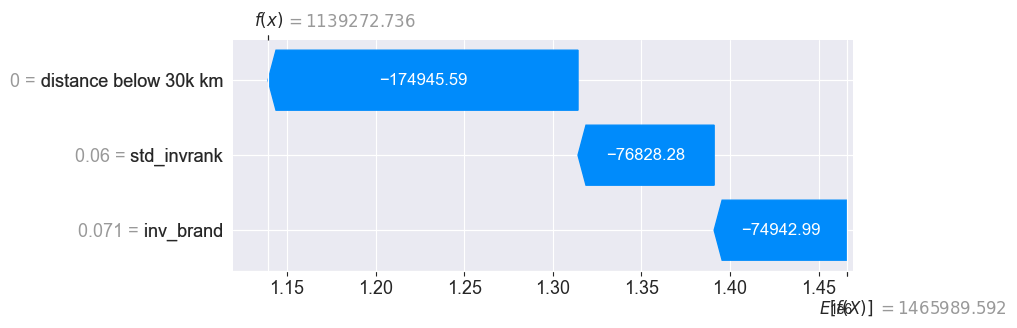

In [1008]:
shap.plots.waterfall(shap_values[0], max_display=14)

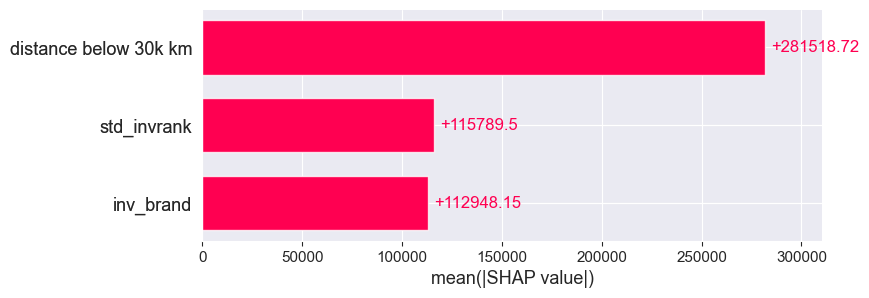

In [1009]:
shap.plots.bar(shap_values, max_display=14)

As we see, the most impactful feature is `distance below 30k km`, while other has pretty similar impact.
# Conclusion
It is pretty hard to choose a model as there are many factors that you need to also account, as data may be imbalanced, you gotta find best parameters for your case and so on. For another time, I realised how important is that we have good data and how important it is to preprocess it before proceeding to actual data model training as we may get datasets such as the pokemon one where there is a clear imbalance between the data. Thanks to the class balancing methods, we can equalize the entries per class. Also note for myself: don't try to use class balancing methods for regression datasets... Also I discovered new ways of interpreting the model such as LIME and SHAP. Also there are different metrics for regression and classification. I found new ways to select features, which probably are more reliable than picking myself from correlation heatmap.